In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

import regionmask
import xarray as xr

import matplotlib.pyplot as plt
import plotly.express as px

from joblib import dump, load

from tqdm import tqdm

In [79]:
LAND_FEATURES = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per',
 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban']

LAND_DIFF_FEATURES = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff','c4ann_diff', 'c4per_diff',
 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']

# FEATURES = LAND_FEATURES + ["cell_area"]
FEATURES = LAND_DIFF_FEATURES
LABEL = 'ELUC'

# Great Britain, France, Germany, Netherlands, Belgium, Switzerland, Ireland
COUNTRY_NAME_LIST = ["GB", "F", "D", "NL", "B", "CH", "IRL"]

DATA_FILE_PATH = "../data/gcb/merged_aggregated_dataset_1850_2022.zarr.zip"
UPDATE_FILE_PATH = "../data/gcb/BLUE_LUH2-GCB2022_ELUC-committed_gridded_net_1850-2021.nc"

MANUAL_MAP = {
    "INDO": 360,
    "DRC": 180,
    "RUS": 643,
    "N": 578,
    "F": 250,
    "J": 388,
    "NA": 516,
    "PAL": 275,
    "J": 400,
    "IRQ": 368,
    "IND": 356,
    "IRN": 364,
    "SYR": 760,
    "ARM": 51,
    "S": 752,
    "A": 36,
    "EST": 233,
    "D": 276,
    "L": 442,
    "B": 56,
    "P": 620,
    "E": 724,
    "IRL": 372,
    "I": 380,
    "SLO": 705,
    "FIN": 246,
    "J": 392,
    "BiH": 70,
    "NM": 807,
    "KO": 383,
    "SS": 728
}

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries_df = countries.to_dataframe()

codes_df = pd.read_csv("../data/gcb/conversion/codes.csv")

# Replace all the bad codes with their real ones
for i in range(len(countries_df)):
    old_abbrev = countries_df.iloc[i]["abbrevs"]
    if old_abbrev in MANUAL_MAP.keys() and MANUAL_MAP[old_abbrev] in codes_df["Numeric code"].unique():
        countries_df.iloc[i]["abbrevs"] = codes_df[codes_df["Numeric code"] == MANUAL_MAP[old_abbrev]]["Alpha-2 code"].iloc[0]

In [3]:
print(countries_df.head())
print(countries_df[countries_df["abbrevs"] == "GB"].index)

        abbrevs                     names
numbers                                  
0            FJ                      Fiji
1            TZ                  Tanzania
2            WS                 W. Sahara
3            CA                    Canada
4            US  United States of America
Int64Index([143], dtype='int64', name='numbers')


## Data Preprocessing

In [4]:
def import_data(path, update_path):
    raw = xr.open_zarr(path, consolidated=True)

    # Get updated ELUC
    if update_path:
        eluc = xr.open_dataset(update_path)
        raw = raw.drop_vars(["ELUC", "cell_area"])
        raw = raw.merge(eluc)

    # Shift actions back a year
    raw[LAND_DIFF_FEATURES] = raw[LAND_DIFF_FEATURES].shift(time=-1)

    # Old time shifting
    # raw['ELUC'] = raw['ELUC'].shift(time=1)
    # raw['ELUC_diff'] = raw['ELUC_diff'].shift(time=1)
    # raw['time'] = raw.time - 1
    # assert(list(np.unique(raw.time)) == list(range(1849, 2022)))

    mask = raw["ELUC_diff"].isnull().compute()
    raw = raw.where(~mask, drop=True)

    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(raw)
    raw["country"] = country_mask
    return raw

In [28]:
def subset_countries(df, countries):
    idx = countries_df[countries_df["abbrevs"].isin(countries)].index.values
    return df[df["country"].isin(idx)]

def da_to_df(da, start_year=None, end_year=None, countries=None):
    df = da.to_dataframe()
    df = df.dropna()
    df['country_name'] = countries_df.loc[df['country'], 'names'].values
    if start_year:
        df = df.loc[start_year:]
    if end_year:
        df = df.loc[:end_year]
    if countries:
        df = subset_countries(df, countries)
        
    return df

In [10]:
class Scaler:
    def __init__(self):
        self.means = None
        self.stdevs = None

    def fit(self, X_train):
        self.means = X_train.mean(axis=0)
        self.stdevs = X_train.std(axis=0)
        # Replace 0 stdevs with 1 so we don't divide by 0
        self.stdevs = self.stdevs.replace(0, 1)

    def transform(self, X):
        return (X - self.means) / self.stdevs
    
    def fit_transform(self, X_train):
        self.fit(X_train)
        return self.transform(X_train)

In [8]:
print("Loading data...")
raw = import_data(DATA_FILE_PATH, UPDATE_FILE_PATH)

Loading data...


/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of c

(435183, 12)
(27030, 12)


In [13]:
df = da_to_df(raw)
print(df.shape)
df.head()

(41387985, 31)


ELUC_diff         c3ann    c3ann_diff         c3nfx  \
time lat     lon                                                               
1851 -55.375 -69.375  1.585186e-04  1.529372e-07 -1.466177e-09  0.000000e+00   
             -69.125 -1.669832e-09  6.256299e-08 -4.925624e-10  8.209591e-09   
             -68.875  3.134616e-07  2.541674e-08  3.165289e-08  0.000000e+00   
             -68.625 -2.126626e-08  6.788947e-08 -7.737526e-10  0.000000e+00   
             -68.375 -8.974894e-09  1.061018e-06 -5.096126e-09  0.000000e+00   

                        c3nfx_diff         c3per    c3per_diff         c4ann  \
time lat     lon                                                               
1851 -55.375 -69.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -69.125 -6.463452e-11  1.742937e-08 -1.372218e-10  8.359032e-09   
             -68.875  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.625  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                        c4ann_diff  c4per  ...    secdf_diff     secdn  \
time lat     lon                           ...                           
1851 -55.375 -69.375  0.000000e+00    0.0  ...  1.048539e-04  0.000000   
             -69.125 -6.581136e-11    0.0  ... -1.396984e-09  0.000000   
             -68.875  0.000000e+00    0.0  ...  0.000000e+00  0.000034   
             -68.625  0.000000e+00    0.0  ...  0.000000e+00  0.000038   
             -68.375  0.000000e+00    0.0  ...  0.000000e+00  0.000044   

                        secdn_diff  urban  urban_diff          ELUC  \
time lat     lon                                                      
1851 -55.375 -69.375  0.000000e+00    0.0         0.0  4.283220e-03   
             -69.125  0.000000e+00    0.0         0.0 -3.430041e-07   
             -68.875 -3.637979e-12    0.0         0.0  3.217266e-06   
             -68.625  5.940819e-09    0.0         0.0 -7.565677e-08   
             -68.375 -3.637979e-12    0.0         0.0 -3.761452e-07   

                         cell_area  mask  country  country_name  
time lat     lon                                                 
1851 -55.375 -69.375  43908.949219   1.0     10.0         Chile  
             -69.125  43908.949219   1.0     10.0         Chile  
             -68.875  43908.949219   1.0     10.0         Chile  
             -68.625  43908.949219   1.0     10.0         Chile  
             -68.375  43908.949219   1.0     10.0         Chile  

[5 rows x 31 columns]

In [ ]:
eu_df = subset_countries(df, COUNTRY_NAME_LIST)
print(eu_df.shape)
eu_df.head()

## Model

### Train general model

In [26]:
def eval_model(model, df, test_year):
    test = df.loc[test_year:]
    X_test = test[FEATURES]
    y_test = test[LABEL]
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

def train_model(df, test_year):
    model = LinearRegression(n_jobs=-1)
    train = df.loc[:test_year]
    X_train = train[FEATURES]
    y_train = train[LABEL]
    model.fit(X_train, y_train)
    mae = eval_model(model, df, test_year)
    return model, mae

In [37]:
def plot_model_weights(model, title):
    plt.bar(LAND_DIFF_FEATURES, model.coef_)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

total mae: 0.07230156660079956
eu mae: 0.14098775386810303


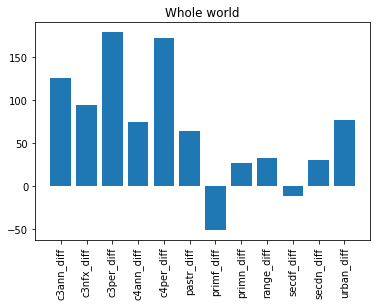

In [39]:
model, mae = train_model(df, 2012)
print(f"total mae: {mae}")

whole_eu_mae = eval_model(model, eu_df, 2012)
print(f"eu mae: {whole_eu_mae}")

plot_model_weights(model, "Whole world")

eu mae: 0.03312671184539795


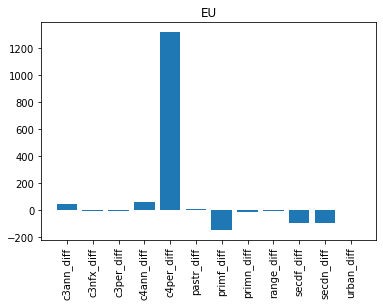

In [43]:
eu_model, eu_mae = train_model(eu_df, 2012)
print(f"eu mae: {eu_mae}")

plot_model_weights(eu_model, "EU")

In [22]:
def find_best_start_year(df, test_year, verbose=0):
    years_df = pd.DataFrame(columns=df.columns)
    years = list(range(1852, test_year + 10, 10))

    test = df.loc[years[-1]:]
    X_test = test[FEATURES]
    y_test = test[LABEL]

    best_mae = np.inf
    best_year = None
    best_model = None
    for i in range(1, len(years)):
        start = years[len(years) - i - 1]
        end = years[len(years) - i]
        to_append = df.loc[start:end]
        years_df = pd.concat((years_df, to_append), axis=0)
        
        X_train = years_df[FEATURES]
        y_train = years_df[LABEL]
        model = LinearRegression(n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        if verbose > 0:
            print(f"{start} : {mae}")

        if mae < best_mae:
            best_mae = mae
            best_year = start
            best_model = model

    return best_model, best_mae, best_year

### Tune on specific regions

#### United States

In [ ]:
countries_df[countries_df["names"] == "United Kingdom"]

,abbrevs,names
numbers,,
143,GB,United Kingdom


#### Europe

In [ ]:
eu_idx = countries_df[countries_df["abbrevs"].isin(COUNTRY_NAME_LIST)].index.values
eu_df = df[df["country"].isin(eu_idx)]
eu_model, eu_year, eu_mae = find_best_start_year(eu_df)
print(f"EU: {eu_mae}")

# dump(eu_model, f"../demo/predictors/countries/143_linear.joblib")

EU: 0.02580469287931919


['../demo/predictors/countries/143_linear.joblib']

#### Greedy Search

In [ ]:
start_country = "F"


#### Brazil

In [ ]:
brazil_countries = ["Brazil", "Bolivia", "Paraguay", "Peru", "Ecuador", "Colombia", "Venezuela", "Guyana", "Suriname", "French Guiana", "Uruguay", "Argentina", "Chile"]
brazil_idx = countries_df[countries_df["names"].isin(brazil_countries)].index.values
brazil_df = df[df["country"].isin(brazil_idx)]
brazil_model, brazil_year, brazil_mae = find_best_start_year(brazil_df)

test_idx = countries_df[countries_df["names"] == "Brazil"].index[0]
test = df[df["country"]==test_idx]
test = df.loc[2012:]
X_test = test[FEATURES]
y_test = test[LABEL]
print(mean_absolute_error(y_test, brazil_model.predict(X_test)))

# dump(brazil_model, f"../demo/predictors/countries/{test_idx}_linear.joblib")


0.11708375


['../demo/predictors/countries/29_linear.joblib']

In [ ]:
i = 4

#### Plot differences between individual models and general one

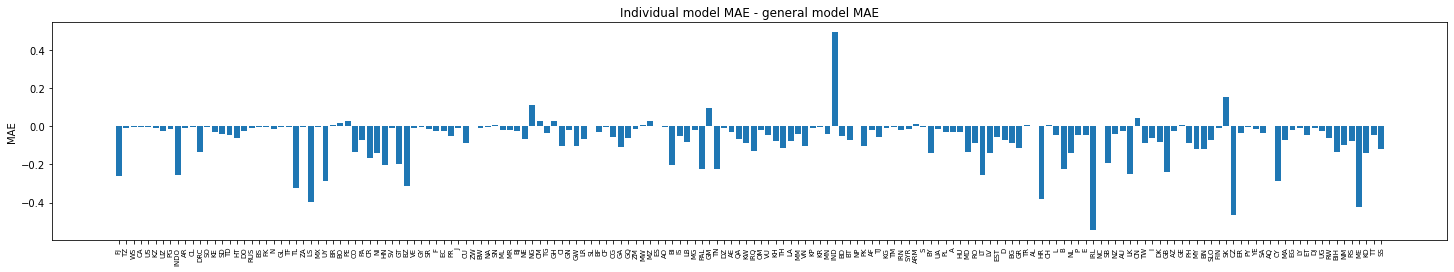

In [ ]:
diffs = [mae - big_mae for mae, big_mae in zip(maes, big_maes)]
plt.figure(figsize=(25, 4))
plt.title("Individual model MAE - general model MAE")
plt.ylabel("MAE")
plt.bar(countries_df["abbrevs"], diffs)
plt.xticks(rotation=90, fontsize=7)
plt.show()

### Train by latitude

In [14]:
def train_lat_zones(df, lat_zones):
    idx_vals = df.index.get_level_values('lat')
    lat_models = []
    tae = 0
    n = 0
    for i, zone in enumerate(lat_zones):
        pos = (idx_vals >= zone[0]) & (idx_vals < zone[1])
        neg = (idx_vals <= -zone[0]) & (idx_vals > -zone[1])
        df_zone = df.loc[(pos) | (neg)]

        model, year, mae = find_best_start_year(df_zone)
        lat_models.append(model)

        time_vals = df_zone.index.get_level_values('time')
        num = len(df_zone.loc[time_vals >= 2012])
        tae += num * mae
        n += num
        print(f"{zone} : {year} : {num} : {mae}")


    print(f"tmae : {tae / n}")
    return lat_models

def eval_lat_models_countries(df, lat_models, lat_zones, test_year):
    idx_vals = df.index.get_level_values('lat')
    for i, zone in enumerate(lat_zones):
        print(f"Zone: {zone}")
        pos = (idx_vals >= zone[0]) & (idx_vals < zone[1])
        neg = (idx_vals <= -zone[0]) & (idx_vals > -zone[1])
        df_zone = df.loc[(pos) | (neg)]
        for country in df_zone["country"].unique():
            df_country = df_zone[df_zone["country"] == country]
            test = df_country.loc[test_year:]
            X_test = test[FEATURES]
            y_test = test[LABEL]
            model = lat_models[i]
            y_pred = model.predict(X_test)
            print(f"\t{countries_df.iloc[int(country)]['names']} : {mean_absolute_error(y_test, y_pred)}")

In [15]:
lat_zones = [(0, 23.5), (23.5, 40), (40, 60), (60, 90)]
#lat_zones = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 60), (60, 90)]
lat_models = train_lat_zones(df, lat_zones)
eval_lat_models_countries(df, lat_models, lat_zones, 2012)

#lat_models_full = train_lat_zones(df, lat_zones, train_year_range, deploy=True)

(0, 23.5) : 2002 : 654250 : 0.10516833513975143
(23.5, 40) : 1872 : 537450 : 0.0719539150595665
(40, 60) : 1862 : 636340 : 0.06187371164560318
(60, 90) : 1962 : 592310 : 0.006592103745788336
tmae : 0.06228657076545847
Zone: (0, 23.5)
	Chile : 0.004657070618122816
	Argentina : 0.05517253279685974
	Paraguay : 0.21034173667430878
	Brazil : 0.17116178572177887
	Namibia : 0.010462622158229351
	Botswana : 0.015911279246211052
	South Africa : 0.012933804653584957
	Mozambique : 0.05408736690878868
	Madagascar : 0.08428777754306793
	Australia : 0.03479412570595741
	Bolivia : 0.0650295540690422
	Zimbabwe : 0.049378711730241776
	New Caledonia : 0.024725956842303276
	Peru : 0.07732682675123215
	Fiji : 0.311270147562027
	Angola : 0.09140355885028839
	Zambia : 0.0755486711859703
	Malawi : 0.06590357422828674
	Vanuatu : 0.0977180153131485
	Dem. Rep. Congo : 0.11972624063491821
	Tanzania : 0.12938565015792847
	Papua New Guinea : 0.00931924395263195
	Solomon Is. : 0.16999788582324982
	Indonesia : 0.179

### Map Code

In [16]:
def manual_map(code):
    return MANUAL_MAP[code] if code in MANUAL_MAP.keys() else np.nan

def map_plot_results(maes):
    results_df = pd.DataFrame({"name": list(countries_df["names"]), "code": list(countries_df["abbrevs"]), "mae": maes})
    print(results_df.shape)
    results_df["num"] = results_df["code"].apply(manual_map)
    codes_df = pd.read_csv("../data/gcb/conversion/codes.csv")
    merged_alpha = results_df.merge(codes_df, how="inner", left_on="code", right_on="Alpha-2 code")
    print(merged_alpha.shape)
    merged_num = results_df.merge(codes_df, how="inner", left_on="num", right_on="Numeric code")
    print(merged_num.shape)

    final = pd.concat([merged_alpha, merged_num])
    print(final.shape)

    print(results_df[~results_df["name"].isin(final["name"])])

    fig=px.choropleth(final, locations="Alpha-3 code", color="mae", hover_name="English short name lower case")
    fig.show()

In [17]:
#map_plot_results(maes)

### One big model

In [33]:
def train_big_model(df, verbose=0):
    model, year, mae = find_best_start_year(df, verbose=verbose)
    print(f"total : {year} : {mae}")
    return model

def eval_big_countries(df, model):
    for country in df["country"].unique():
        df_country = df[df["country"] == country]
        test = df_country.loc[2012:]
        X_test = test[FEATURES]
        y_test = test[LABEL]
        y_pred = model.predict(X_test)
        print(f"\t{countries_df.iloc[int(country)]['names']} : {mean_absolute_error(y_test, y_pred)}")

In [34]:
big_model = train_big_model(df)
#dump(big_model, "../demo/predictors/ELUC_linear.joblib")
eval_big_countries(df, big_model)

total : 1862 : 0.07320143282413483
	Chile : 0.05935186892747879
	Argentina : 0.0332520455121994
	Falkland Is. : 0.003422390902414918
	Fr. S. Antarctic Lands : 0.0035780523903667927
	New Zealand : 0.17733795940876007
	Australia : 0.05035422369837761
	Uruguay : 0.3056822121143341
	South Africa : 0.015447142533957958
	Brazil : 0.22473694384098053
	Lesotho : 0.4361390769481659
	Namibia : 0.005597725044935942
	Paraguay : 0.20393122732639313
	eSwatini : 0.009923632256686687
	Botswana : 0.010391957126557827
	Mozambique : 0.05319204181432724
	Madagascar : 0.10618831217288971
	Bolivia : 0.06632786244153976
	Zimbabwe : 0.03028523176908493
	New Caledonia : 0.0074117956683039665
	Peru : 0.07493804395198822
	Fiji : 0.2557278871536255
	Angola : 0.09498321264982224
	Zambia : 0.09397637099027634
	Malawi : 0.05719132721424103
	Vanuatu : 0.12367340177297592
	Dem. Rep. Congo : 0.21152909100055695
	Tanzania : 0.11971926689147949
	Papua New Guinea : 0.024857763200998306
	Solomon Is. : 0.2135429084300995
	I

In [38]:
# big_forest = RandomForestRegressor(random_state=42, n_jobs=-1)
# test = df.loc[2012:]
# X_test = test[FEATURES]
# y_test = test[LABEL]

# train = df.loc[1982:2012]
# X_train = train[FEATURES]
# y_train = train[LABEL]

# big_forest.fit(X_train, y_train)
# y_pred = big_forest.predict(X_test)
# print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# eval_big_countries(df, big_forest)

KeyboardInterrupt: 

### By country

In [20]:
def search_country_time(df):
    models = dict()
    maes = dict()
    times = dict()
    tmae = 0
    n = 0
    for country in df["country"].unique():
        country = int(country)
        df_zone = df[df["country"] == country]
        if len(df_zone) > 0:
            model, year, mae = find_best_start_year(df_zone)
            models[country] = model
            maes[country] = mae
            times[country] = year

            # For computing tmae
            time_idx = df_zone.index.get_level_values('time')
            num = len(df_zone.loc[time_idx >= 2012])
            n += num
            tmae += num * mae
            
            print(f"{countries_df.iloc[int(country)]['names']} : {year} : {num} : {mae}")

    print(f"tmae: {tmae / n}")

    return models, maes, times, tmae

In [21]:
models, maes, times, tmae = search_country_time(df)

Chile : 1992 : 12470 : 0.05250595510005951
Argentina : 1962 : 41610 : 0.024132506921887398
Falkland Is. : 1952 : 190 : 1.7364521800594664e-19
Fr. S. Antarctic Lands : 2002 : 140 : 0.0
New Zealand : 2002 : 4570 : 0.13517604768276215
Australia : 2002 : 110290 : 0.021834256127476692
Uruguay : 1942 : 2750 : 0.016207514330744743
South Africa : 2002 : 17940 : 0.007175841834396124
Brazil : 2002 : 113030 : 0.21014809608459473
Lesotho : 1982 : 400 : 0.04406321421265602
Namibia : 1962 : 11690 : 0.0031127119436860085
Paraguay : 2002 : 5690 : 0.1704024225473404
eSwatini : 2002 : 260 : 0.008940009400248528
Botswana : 2002 : 8200 : 0.002552191959694028
Mozambique : 2002 : 10880 : 0.05131052806973457
Madagascar : 1852 : 8000 : 0.07417353987693787
Bolivia : 1852 : 14750 : 0.08182799816131592
Zimbabwe : 2002 : 5170 : 0.025294017046689987
New Caledonia : 1852 : 200 : 0.0058424328453838825
Peru : 1962 : 17060 : 0.09561536461114883
Fiji : 1852 : 200 : 0.0005480592953972518
Angola : 1962 : 16440 : 0.088782

In [22]:
for i in models.keys():
    model = models[i]
    #dump(model, f"../demo/predictors/countries/{i}_linear.joblib")

In [23]:
us_idx = countries_df[countries_df["names"] == "United States of America"].index[0]
print(us_idx)

4


#### United States

In [27]:
countries_df[countries_df["names"] == "United Kingdom"]

,abbrevs,names
numbers,,
143,GB,United Kingdom


#### Europe

In [28]:
eu_idx = countries_df[countries_df["abbrevs"].isin(COUNTRY_NAME_LIST)].index.values
eu_df = df[df["country"].isin(eu_idx)]
eu_model, eu_year, eu_mae = find_best_start_year(eu_df)
print(f"EU: {eu_mae}")

# dump(eu_model, f"../demo/predictors/countries/143_linear.joblib")

EU: 0.02580469287931919


['../demo/predictors/countries/143_linear.joblib']

#### Brazil

In [29]:
brazil_countries = ["Brazil", "Bolivia", "Paraguay", "Peru", "Ecuador", "Colombia", "Venezuela", "Guyana", "Suriname", "French Guiana", "Uruguay", "Argentina", "Chile"]
brazil_idx = countries_df[countries_df["names"].isin(brazil_countries)].index.values
brazil_df = df[df["country"].isin(brazil_idx)]
brazil_model, brazil_year, brazil_mae = find_best_start_year(brazil_df)

test_idx = countries_df[countries_df["names"] == "Brazil"].index[0]
test = df[df["country"]==test_idx]
test = df.loc[2012:]
X_test = test[FEATURES]
y_test = test[LABEL]
print(mean_absolute_error(y_test, brazil_model.predict(X_test)))

# dump(brazil_model, f"../demo/predictors/countries/{test_idx}_linear.joblib")


0.11708375


['../demo/predictors/countries/29_linear.joblib']

In [ ]:
i = 4

#### Plot differences between individual models and general one

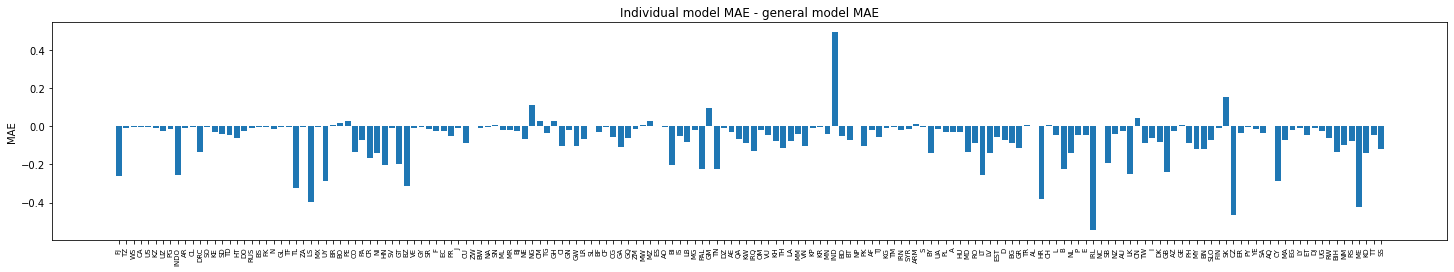

In [29]:
diffs = [mae - big_mae for mae, big_mae in zip(maes, big_maes)]
plt.figure(figsize=(25, 4))
plt.title("Individual model MAE - general model MAE")
plt.ylabel("MAE")
plt.bar(countries_df["abbrevs"], diffs)
plt.xticks(rotation=90, fontsize=7)
plt.show()

### Tune on neighboring countries

In [70]:
codes = pd.read_csv("../data/gcb/conversion/codes.csv")
codes[codes["Numeric code"] == 10]

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
8,Antarctica,AQ,ATA,10,ISO 3166-2:AQ


In [72]:
countries_df

,abbrevs,names
numbers,,
0,FJ,Fiji
1,TZ,Tanzania
2,WS,W. Sahara
3,CA,Canada
4,US,United States of America
...,...,...
172,RS,Serbia
173,ME,Montenegro
174,KO,Kosovo


In [98]:
def k_nearest_countries(country_id, k):
    neighbor_df = pd.read_csv("../data/gcb/conversion/neighbors.csv")
    three_code = codes_df[codes_df["Alpha-2 code"] == country_id]["Alpha-3 code"].iloc[0]
    
    idx = 0
    queue = [three_code]
    seen = set([three_code])
    # Simple BFS to find neighbors
    # Add one because the first element in the queue is our original country
    while idx < len(queue) and len(queue) < k + 1:
        curr = queue[idx]
        neighbors = neighbor_df[neighbor_df["country_code"] == curr]["neighbor_code"]
        for neighbor in list(neighbors):
            if neighbor not in seen:
                queue.append(neighbor)
        idx += 1
    
    if len(queue) > 1:
        return [codes_df[codes_df["Alpha-3 code"] == code]["Alpha-2 code"].iloc[0] for code in queue[1:k+1]]
    
    return []

In [96]:
def find_model_for_country(country_id, raw):
    print(f"Finding best model for {country_id}")
    whole_df = da_to_df(raw)
    print(f"whole len: {len(whole_df)}")

    baseline_df = subset_countries(whole_df, [country_id])
    print(f"baseline len: {len(baseline_df)}")
    best_model, best_mae = train_model(baseline_df, 2012)
    best_countries = [country_id]
    print(f"Baseline score: {best_mae}")

    countries = [country_id]
    k_nearest = k_nearest_countries(country_id, 20)
    print(f"Neighbors: {k_nearest}")
    for neighbor in k_nearest:
        df = subset_countries(whole_df, countries + [neighbor])
        model, mae = train_model(df, 2012)
        if mae < best_mae:
            print(f"\tAdded {neighbor}")
            print(f"\tScore: {mae}")
            best_model = model
            countries.append(neighbor)
            best_countries = countries
            best_mae = mae
    

    print(f"mae: {best_mae}, countries: {list(countries_df[countries_df['abbrevs'].isin(best_countries)]['names'])}")
    return best_model, best_mae, best_countries

In [97]:
best_model, best_mae, best_countries = find_model_for_country("FR", raw)

Finding best model for FR
whole len: 41387985
baseline len: 193059
Baseline score: 0.017622433602809906
Neighbors: ['BE', 'BR', 'CH', 'DE', 'ES', 'IT', 'LU', 'SR', 'DE', 'LU', 'NL', 'AR', 'BO', 'CO', 'GY', 'PE', 'PY', 'SR', 'UY', 'VE']
	Added BE
	Score: 0.016981830820441246
	Added DE
	Score: 0.011274890974164009
	Added SR
	Score: 0.011138525791466236
	Added LU
	Score: 0.011135482229292393
mae: 0.011135482229292393, countries: numbers
42       Suriname
43         France
121       Germany
128    Luxembourg
129       Belgium
Name: names, dtype: object


### Tune on best year to train on

In [16]:
def find_best_year(raw, country_mask, country_list):
    X_train = pd.DataFrame(columns=FEATURES)
    y_train = pd.Series(name=LABEL, dtype=float)
    X_test = None
    y_test = None
    years = list(range(2012, 1851, -10))
    maes = []
    best_model = None
    best_mae = None
    for i in range(1, len(years)):
        print(f"Adding {years[i]}-{years[i-1]-1} to train set...")
        data = create_country_dataset(raw, country_mask, country_list, years[i], years[i-1]-1)
        X_train = pd.concat((X_train, data["Train"]["X"]), axis=0)
        y_train = pd.concat((y_train, data["Train"]["y"]))
        if i == 1:
            X_test = data["Test"]["X"]
            y_test = data["Test"]["y"]

        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        print(f"MAE: {mae}")
        maes.append(mae)

        if not best_mae or best_mae > mae:
            best_model = model
            best_mae = mae
    
    plt.plot(years[1:], maes)
    plt.xticks(rotation=90)
    plt.title(f"Year train set started vs. MAE for {' '.join(country_list)}")
    plt.xlabel("Year")
    plt.ylabel("MAE")
    plt.show()

    return best_model, maes
        

Adding 2002-2011 to train set...
MAE: 0.03648469909050712
Adding 1992-2001 to train set...
MAE: 0.03710089250796529
Adding 1982-1991 to train set...
MAE: 0.037174860283775146
Adding 1972-1981 to train set...
MAE: 0.037956103687055286
Adding 1962-1971 to train set...
MAE: 0.038082952563230514
Adding 1952-1961 to train set...
MAE: 0.03796119643580342
Adding 1942-1951 to train set...
MAE: 0.037907506265799785
Adding 1932-1941 to train set...
MAE: 0.03792129119454972
Adding 1922-1931 to train set...
MAE: 0.03834665424151246
Adding 1912-1921 to train set...
MAE: 0.03839517526179118
Adding 1902-1911 to train set...
MAE: 0.03840008108683362
Adding 1892-1901 to train set...
MAE: 0.03820898943408478
Adding 1882-1891 to train set...
MAE: 0.038035298970404495
Adding 1872-1881 to train set...
MAE: 0.037873564280927814
Adding 1862-1871 to train set...
MAE: 0.03822668028038931
Adding 1852-1861 to train set...
MAE: 0.03859580199673611


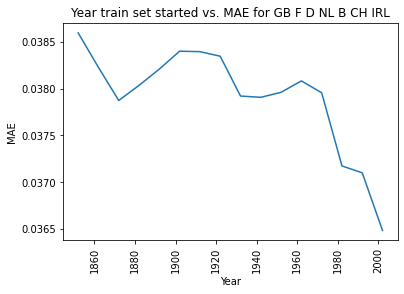

In [17]:
best_model, maes = find_best_year(raw, country_mask, COUNTRY_NAME_LIST)

## Model Analysis

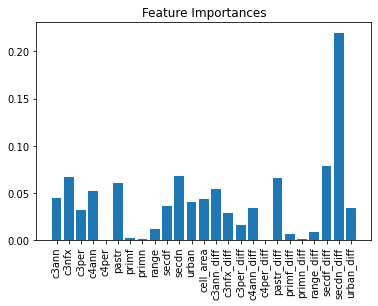

In [20]:
plt.bar(data["Train"]["X"].columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.show()

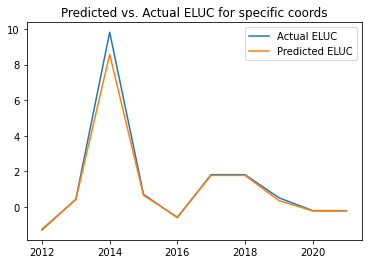

In [19]:
X_irl = data["Test"]["X"].loc[:, 54.125, -6.875]
y_irl = data["Test"]["y"].loc[:, 54.125, -6.875]

preds = model.predict(X_irl)

times = list(data["Test"]["X"].index.unique(level="time"))
plt.title("Predicted vs. Actual ELUC for specific coords")
plt.plot(times, y_irl, label="Actual ELUC")
plt.plot(times, preds, label="Predicted ELUC")
plt.legend()
plt.show()

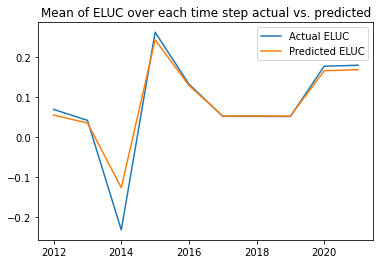

In [20]:
preds = model.predict(data["Test"]["X"])
test_copy = data["Test"]["X"].copy()
test_copy["pred"] = preds
test_copy["ELUC"] = data["Test"]["y"]
pred_eluc_sums = []
eluc_sums = []
for time in times:
    pred_eluc_sums.append(test_copy.loc[time, :, :]["pred"].mean())
    eluc_sums.append(test_copy.loc[time, :, :]["ELUC"].mean())

plt.title("Mean of ELUC over each time step actual vs. predicted")
plt.plot(times, eluc_sums, label="Actual ELUC")
plt.plot(times, pred_eluc_sums, label="Predicted ELUC")
plt.legend()
plt.show()